# 05 Variant Reclassification based on DDG_folding and DDG_binding

## 5.1 Folding Threshold

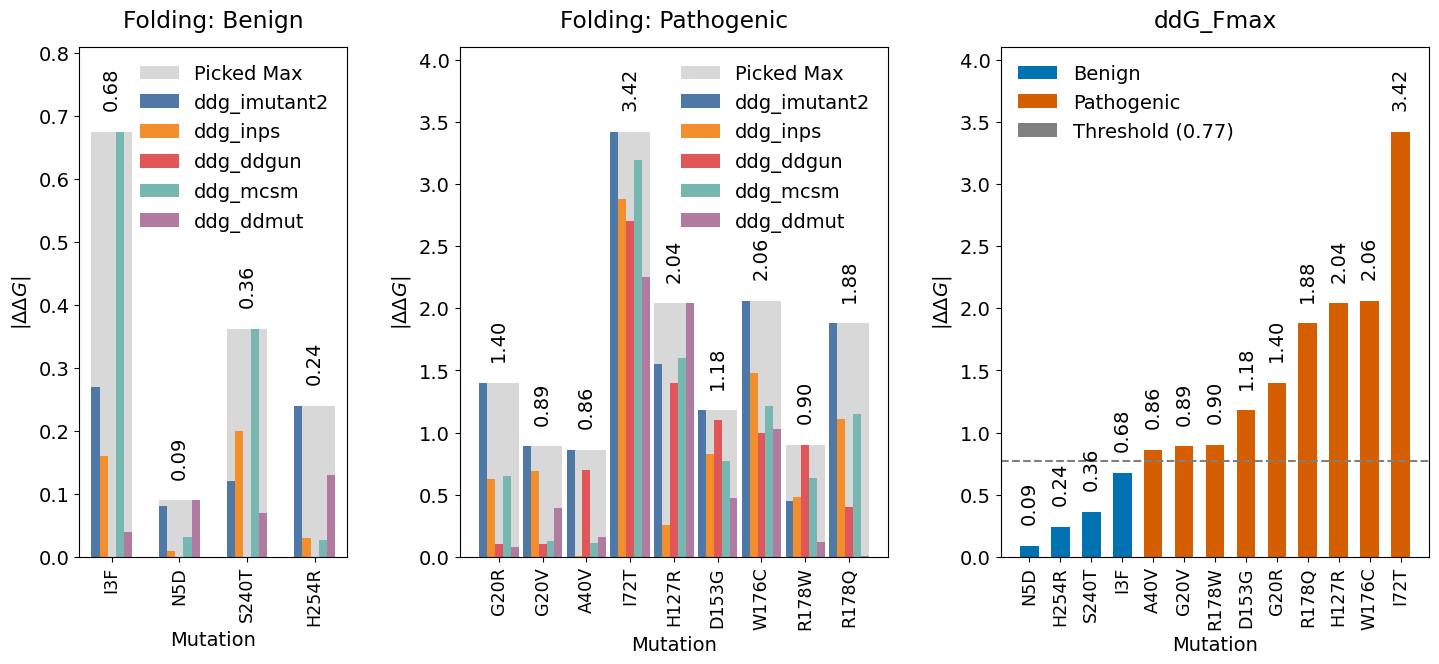

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ─── Setup ───────────────────────────────────────────────────────────────────
output_dir = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# ─── Data loading & preprocessing ─────────────────────────────────────────────
folding_path = (
    "/project/ealexov/compbio/shamrat/250519_energy/02_folding/"
    "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx"
)
df = pd.read_excel(folding_path)
df = df[df['position'].between(1, 302)]

# Structure‐based ΔΔG cols (exclude FoldX) + max
str_cols = [c for c in df.columns if c.endswith('_str') and 'foldx' not in c.lower()]
df['ddG_Fmax'] = df[str_cols].abs().max(axis=1)

# Split into benign/pathogenic dicts
ben_data  = {
    r['mutation']: {
        'pos': r['position'],
        **{c.replace('_str',''): abs(r[c]) for c in str_cols},
        'max': r['ddG_Fmax']
    }
    for _,r in df[df['Germline classification']=='Benign'].iterrows()
}
path_data = {
    r['mutation']: {
        'pos': r['position'],
        **{c.replace('_str',''): abs(r[c]) for c in str_cols},
        'max': r['ddG_Fmax']
    }
    for _,r in df[df['Germline classification']=='Pathogenic'].iterrows()
}

methods = [c.replace('_str','') for c in str_cols]
colors  = ['#4E79A7','#F28E2B','#E15759','#76B7B2','#B07AA1']

# ─── Plot functions with adjustable bar_width ──────────────────────────────────
def annotate_bars(ax, xs, heights, cfg):
    top = max(heights)
    for x, h in zip(xs, heights):
        ax.text(
            x, h + top*cfg.annot_offset, f"{h:.2f}",
            ha='center', va='bottom', rotation=90,
            clip_on=False, fontsize=cfg.annot_fontsize
        )

def finalize_axes(ax, ytops, cfg):
    ax.set_ylim(0, max(ytops)*cfg.y_headroom)
    ax.tick_params(axis='x', labelsize=cfg.base_fontsize*0.9)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
    ax.grid(False)

def plot_bar_panel(ax, data, title, cfg, bar_width=None):
    w = bar_width if bar_width is not None else cfg.bar_width
    items = sorted(data.items(), key=lambda x: x[1]['pos'])
    muts = [m for m,_ in items]
    x    = np.arange(len(muts))
    vals = np.array([[d[m] for m in methods] for _,d in items])
    maxv = np.array([d['max'] for _,d in items])

    ax.bar(x, maxv, w*len(methods), color='grey', alpha=cfg.bar_alpha)
    for i in range(len(methods)):
        ax.bar(
            x + (i-(len(methods)-1)/2)*w,
            vals[:,i],
            w,
            color=colors[i]
        )

    annotate_bars(ax, x, maxv, cfg)
    ax.set_xticks(x)
    ax.set_xticklabels(muts)
    ax.set_xlabel('Mutation')              # <-- added x-axis label here
    ax.set_ylabel(r'$|\Delta\Delta G|$')
    ax.set_title(title, loc='center', pad=cfg.title_pad)
    handles = [Patch(facecolor='grey', alpha=cfg.bar_alpha, label='Picked Max')] + [
        Patch(facecolor=colors[i], label=methods[i]) for i in range(len(methods))
    ]
    ax.legend(handles, [h.get_label() for h in handles],
              loc='upper right', frameon=False, fontsize=cfg.legend_fontsize)
    finalize_axes(ax, list(maxv), cfg)

def plot_threshold_panel(ax, cfg, bar_width=None):
    w = bar_width if bar_width is not None else cfg.bar_width
    sub = df[df['Germline classification'].isin(['Benign','Pathogenic'])]
    idx = np.argsort(sub['ddG_Fmax'].values)
    muts = sub['mutation'].values[idx]
    vals = sub['ddG_Fmax'].values[idx]
    grps = sub['Germline classification'].values[idx]
    thr  = (
        sub[sub['Germline classification']=='Benign']['ddG_Fmax'].max()
      + sub[sub['Germline classification']=='Pathogenic']['ddG_Fmax'].min()
    )/2

    cmap = {'Benign':'#0072B2','Pathogenic':'#D55E00'}
    ax.bar(muts, vals, w, color=[cmap[g] for g in grps])
    ax.axhline(thr, color='grey', linestyle='--')

    annotate_bars(ax, np.arange(len(vals)), vals, cfg)
    ax.set_xlabel('Mutation')
    ax.set_ylabel(r'$|\Delta\Delta G|$')
    ax.set_title(r'ddG_Fmax', loc='center', pad=cfg.title_pad)
    handles = [
        Patch(facecolor='#0072B2', label='Benign'),
        Patch(facecolor='#D55E00', label='Pathogenic'),
        Patch(facecolor='grey',    label=f'Threshold ({thr:.2f})')
    ]
    ax.legend(handles, [h.get_label() for h in handles],
              loc='upper left', frameon=False, fontsize=cfg.legend_fontsize)
    finalize_axes(ax, list(vals)+[thr], cfg)

# ─── Panel layout helper ───────────────────────────────────────────────────────
def create_panels(cfg, width_ratios):
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=cfg.figsize)
    gs  = GridSpec(1, 3, width_ratios=width_ratios,
                   left=0.05, right=0.95, top=0.95, bottom=0.1, wspace=0.3)
    axes = [fig.add_subplot(gs[0,i]) for i in range(3)]
    return fig, axes

# ─── Style config ──────────────────────────────────────────────────────────────
class StyleConfig:
    def __init__(self):
        self.base_fontsize   = 14
        self.annot_fontsize  = 14
        self.legend_fontsize = 14
        self.title_pad       = 14
        self.annot_offset    = 0.05
        self.bar_alpha       = 0.3
        self.bar_width       = 0.15
        self.figsize         = (15,6)
        self.dpi             = 300
        self.y_headroom      = 1.2

def apply_global_style(cfg):
    plt.rcParams.update({'font.size': cfg.base_fontsize})

# ─── Run plotting ──────────────────────────────────────────────────────────────
cfg = StyleConfig()
apply_global_style(cfg)

# choose relative widths and individual bar widths per panel:
width_ratios = (0.5, 0.8, 0.8)
bar_widths   = (0.12, 0.18, 0.60)

fig, axes = create_panels(cfg, width_ratios)

plot_bar_panel(axes[0], ben_data,  'Folding: Benign',     cfg, bar_width=bar_widths[0])
plot_bar_panel(axes[1], path_data, 'Folding: Pathogenic', cfg, bar_width=bar_widths[1])
plot_threshold_panel(axes[2], cfg,                                bar_width=bar_widths[2])

out = os.path.join(output_dir, "folding_custom_widths.png")
fig.savefig(out, dpi=cfg.dpi, bbox_inches='tight')
plt.show()


## 5.2 Binding Threshold

In [ ]:
# after loaded df, ben_data, path_data —

# 1. Recompute the classification threshold:
ben_max  = df.loc[df['Germline classification']=='Benign','ddG_Fmax'].max()
path_min = df.loc[df['Germline classification']=='Pathogenic','ddG_Fmax'].min()
thr = (ben_max + path_min) / 2

# 2. Print overall counts and threshold:
print(f"Total Benign variants:    {len(ben_data)}")
print(f"Total Pathogenic variants: {len(path_data)}")
print(f"Classification threshold (midpoint): {thr:.2f}\n")

# 3. Function to pretty-print each dict:
def print_variant_table(data, label):
    print(f"---- {label} ----")
    print("Mutation\tPos\tMax|ΔΔG|\t" + "\t".join(methods))
    for muts, info in sorted(data.items(), key=lambda x: x[1]['pos']):
        row = [
            muts,
            str(info['pos']),
            f"{info['max']:.2f}"
        ] + [f"{info[m]:.2f}" for m in methods]
        print("\t".join(row))
    print()

# 4. Call it for benign and pathogenic:
print_variant_table(ben_data,  "Benign variants")
print_variant_table(path_data, "Pathogenic variants")


Total Benign variants:    4
Total Pathogenic variants: 9
Classification threshold (midpoint): 0.77

---- Benign variants ----
Mutation	Pos	Max|ΔΔG|	ddg_imutant2	ddg_inps	ddg_ddgun	ddg_mcsm	ddg_ddmut
I3F	3	0.68	0.27	0.16	0.00	0.68	0.04
N5D	5	0.09	0.08	0.01	0.00	0.03	0.09
S240T	240	0.36	0.12	0.20	0.00	0.36	0.07
H254R	254	0.24	0.24	0.03	0.00	0.03	0.13

---- Pathogenic variants ----
Mutation	Pos	Max|ΔΔG|	ddg_imutant2	ddg_inps	ddg_ddgun	ddg_mcsm	ddg_ddmut
G20R	20	1.40	1.40	0.63	0.10	0.65	0.08
G20V	20	0.89	0.89	0.69	0.10	0.13	0.39
A40V	40	0.86	0.86	0.01	0.70	0.11	0.16
I72T	72	3.42	3.42	2.88	2.70	3.19	2.25
H127R	127	2.04	1.55	0.26	1.40	1.60	2.04
D153G	153	1.18	1.18	0.83	1.10	0.77	0.47
W176C	176	2.06	2.06	1.48	1.00	1.21	1.03
R178W	178	0.90	0.45	0.48	0.90	0.64	0.12
R178Q	178	1.88	1.88	1.11	0.40	1.15	0.01



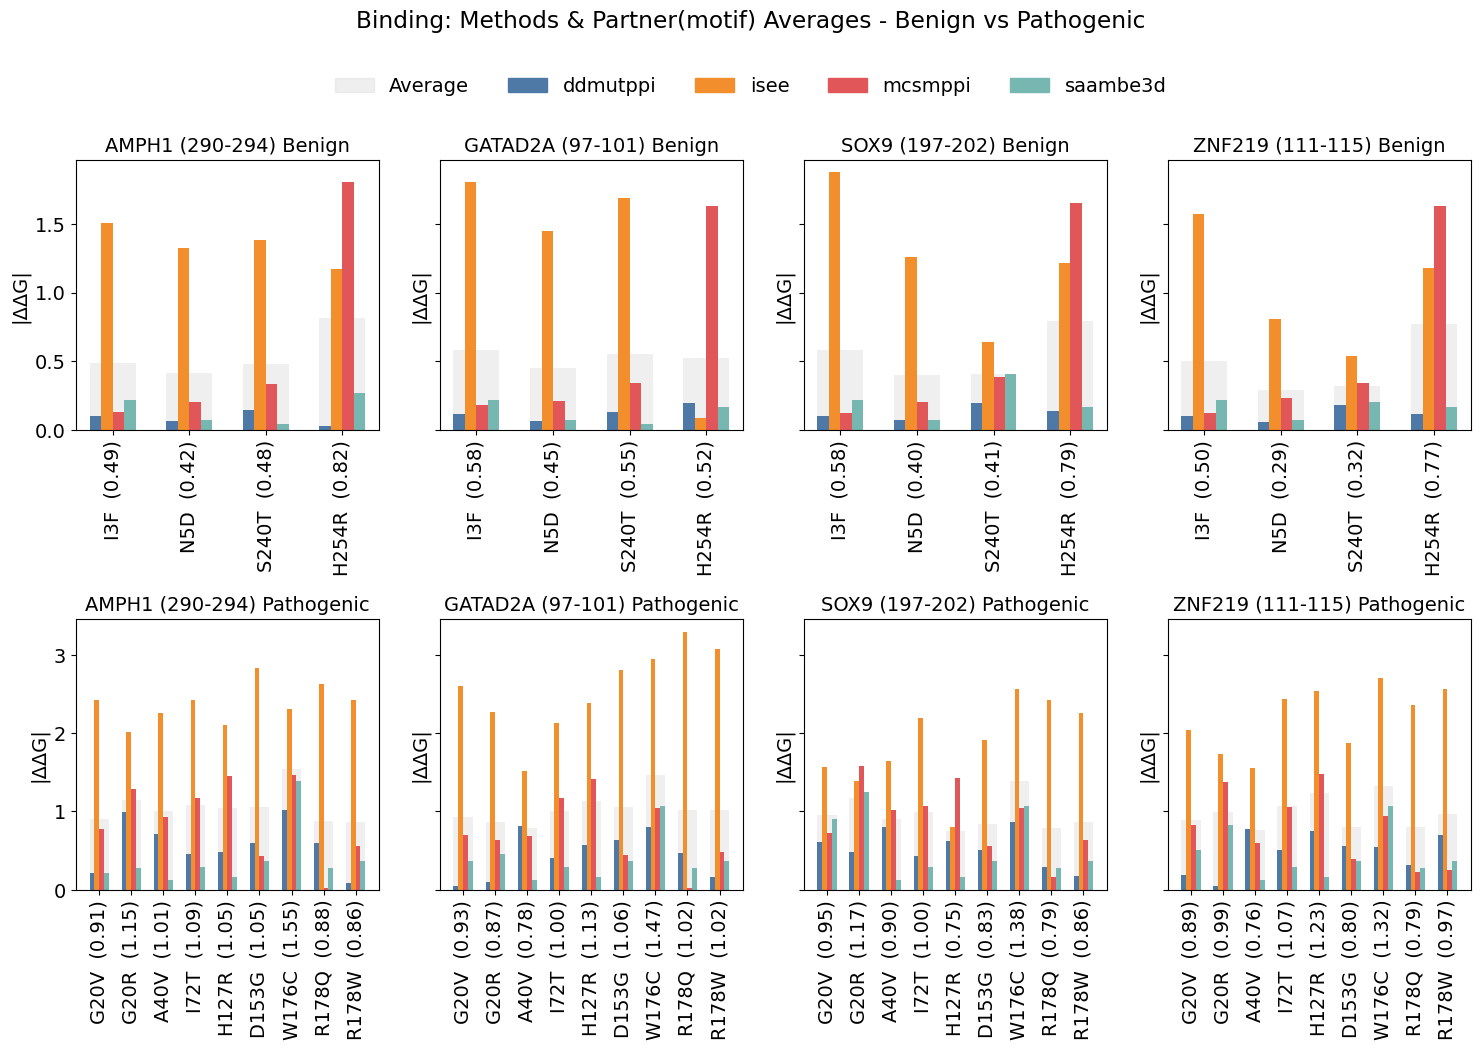

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Turn off all grids
plt.rcParams.update({'axes.grid': False})


def configure_figure(fig,
                     top_title: str,
                     legend_handles: list,
                     legend_labels: list,
                     fig_size=(15, 10),
                     font_size=16,
                     title_y=0.95,
                     legend_y=0.90,
                     left=0.05, right=0.98,
                     bottom=0.07, top=0.85,
                     hspace=0.4, wspace=0.3):
    """
    Configure overall figure:
    - fig_size: (width, height) in inches
    - font_size: base font size
    - title_y: y-position of the suptitle
    - legend_y: y-position of the legend
    - left/right/top/bottom: margins
    - hspace/wspace: spacing between subplots
    """
    # set size & font
    fig.set_size_inches(*fig_size)
    plt.rcParams.update({'font.size': font_size})

    # super-title
    fig.suptitle(top_title, fontsize=font_size*1.2, y=title_y)

    # legend just below the title
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, legend_y),
        frameon=False,
        ncol=len(legend_labels)
    )

    # adjust subplot grid
    fig.subplots_adjust(
        left=left,
        right=right,
        top=top,
        bottom=bottom,
        hspace=hspace,
        wspace=wspace
    )


# ─── User parameters: adjust paths and targets ─────────────────────────────────
binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/analysis/clinvar_1kgp_hector_gaf_final_binding.xlsx"
output_dir   = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# Define partners and their consensus motif ranges
targets = {
    "SOX9":    "197-202",
    "AMPH1":   "290-294",
    "GATAD2A": "97-101",
    "ZNF219":  "111-115"
}

# ─── 1. Load & filter data ────────────────────────────────────────────────────
df = pd.read_excel(binding_path, sheet_name="Sheet1")
df = df[df['position'].between(1, 302)]
df = df[df['Germline classification'].isin(['Benign', 'Pathogenic'])].copy()

# ─── 2. Detect ddG columns by partner+motif ──────────────────────────────────
pat = re.compile(
    r'^(ddg_[^_]+_(?P<gene>[^_]+)_(?P<motif>[0-9\-]+)_str)_(?P<method>.+)$'
)
partner_cols = {}
methods = set()
for col in df.columns:
    m = pat.match(col)
    if not m:
        continue
    gene, motif, method = m.group('gene'), m.group('motif'), m.group('method')
    if gene in targets and targets[gene] == motif:
        partner_cols.setdefault(gene, {}).setdefault(method, []).append(col)
        methods.add(method)
# Exclude FoldX
methods = sorted(m for m in methods if 'foldx' not in m.lower())
partners = sorted(partner_cols.keys())

# ─── 3. Compute per-method abs ΔΔG arrays and partner averages ───────────────
benign_methods = {g: {} for g in partners}
patho_methods  = {g: {} for g in partners}
ben_idx  = df.index[df['Germline classification'] == 'Benign']
path_idx = df.index[df['Germline classification'] == 'Pathogenic']

for gene in partners:
    all_cols = [
        col
        for meth in methods
        for col in partner_cols[gene].get(meth, [])
    ]
    df[f"avg_{gene}"] = df[all_cols].abs().mean(axis=1)

    for method in methods:
        cols = partner_cols[gene].get(method, [])
        if cols:
            vals = df[cols].abs().mean(axis=1)
            benign_methods[gene][method] = vals.loc[ben_idx].values
            patho_methods[gene][method]  = vals.loc[path_idx].values
        else:
            benign_methods[gene][method] = np.array([])
            patho_methods[gene][method]  = np.array([])

# ─── 4. Plotting ──────────────────────────────────────────────────────────────
colors    = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2']
avg_color = '#CCCCCC'
width     = 0.15

# create subplots
fig, axes = plt.subplots(2, len(partners), sharey='row')

for row, (group, methods_dict, idx) in enumerate([
    ('Benign',    benign_methods, ben_idx),
    ('Pathogenic', patho_methods, path_idx)
]):
    for col_i, gene in enumerate(partners):
        ax = axes[row, col_i]

        # --- order by ascending 'position' ---
        group_pos = df.loc[idx, 'position'].values
        order     = np.argsort(group_pos)
        muts      = df.loc[idx, 'mutation'].values[order]
        avg_vals  = df.loc[idx, f"avg_{gene}"].values[order]
        vals      = np.vstack([methods_dict[gene][m] for m in methods])[:, order]
        # ------------------------------------

        x = np.arange(len(muts))

        # average background bars
        ax.bar(x, avg_vals, width*len(methods), color=avg_color, alpha=0.3, zorder=1)
        # per-method bars
        for i, m in enumerate(methods):
            ax.bar(
                x + (i - (len(methods)-1)/2) * width,
                vals[i],
                width,
                color=colors[i],
                zorder=2
            )

        # x-axis labels: mutation plus avg on one line
        labels = [f"{mut}  ({avg_vals[i]:.2f})" for i, mut in enumerate(muts)]
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=90, ha='center')

        # subplot title & y-label
        ax.set_title(f"{gene} ({targets[gene]}) {group}", fontsize=14)
        ax.set_ylabel('|ΔΔG|')

# prepare legend
handles = [Patch(color=avg_color, alpha=0.3)] + [Patch(color=c) for c in colors[:len(methods)]]
labels  = ['Average'] + methods

# apply overall configuration
configure_figure(
    fig,
    top_title='Binding: Methods & Partner(motif) Averages - Benign vs Pathogenic',
    legend_handles=handles,
    legend_labels=labels,
    fig_size=(15, 10),
    font_size=14,
    title_y=0.95,
    legend_y=0.90,
    left=0.05,
    right=0.98,
    bottom=0.07,
    top=0.80,
    hspace=0.7,
    wspace=0.2
)

# save and show
out_png = os.path.join(output_dir, "binding_methods_partner_motif_averages.png")
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()


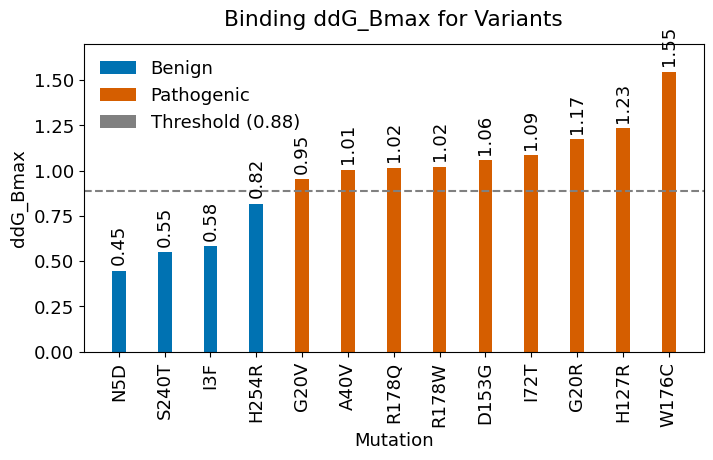

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ─── Style config & helpers ────────────────────────────────────────────────────
class StyleConfig:
    def __init__(self):
        self.base_fontsize   = 13
        self.annot_fontsize  = 13
        self.legend_fontsize = 13
        self.title_pad       = 13
        self.annot_offset    = 0.02
        self.bar_alpha       = 0.3
        self.bar_width       = 0.3
        self.figsize         = (8, 4)
        self.dpi             = 300
        self.y_headroom      = 1.1

def apply_global_style(cfg):
    plt.rcParams.update({'font.size': cfg.base_fontsize, 'axes.grid': False})

def annotate_bars(ax, xs, heights, cfg):
    top = max(heights)
    for x, h in zip(xs, heights):
        ax.text(
            x, h + top * cfg.annot_offset,
            f"{h:.2f}", ha='center', va='bottom',
            rotation=90, fontsize=cfg.annot_fontsize, clip_on=False
        )

def finalize_axes(ax, ytops, cfg):
    ax.set_ylim(0, max(ytops) * cfg.y_headroom)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

def plot_threshold_panel(ax, df, cfg):
    # sort by ddG_Bmax
    sub = df[df['Germline classification'].isin(['Benign','Pathogenic'])]
    order = np.argsort(sub['ddG_Bmax'].values)
    muts = sub['mutation'].values[order]
    vals = sub['ddG_Bmax'].values[order]
    grps = sub['Germline classification'].values[order]

    # compute threshold
    thr = (sub[sub['Germline classification']=='Benign']['ddG_Bmax'].max() +
           sub[sub['Germline classification']=='Pathogenic']['ddG_Bmax'].min()) / 2

    # bar colors
    cmap = {'Benign':'#0072B2','Pathogenic':'#D55E00'}
    colors = [cmap[g] for g in grps]

    # bars
    x = np.arange(len(muts))
    bars = ax.bar(x, vals, cfg.bar_width, color=colors)

    # threshold line (no label here)
    ax.axhline(thr, color='gray', linestyle='--')

    # annotate
    annotate_bars(ax, x, vals, cfg)

    # labels and title
    ax.set_xticks(x)
    ax.set_xticklabels(muts)
    ax.set_xlabel('Mutation')
    ax.set_ylabel('ddG_Bmax')
    ax.set_title('Binding ddG_Bmax for Variants', loc='center', pad=cfg.title_pad)

    # legend patches (including threshold with label)
    patches = [
        Patch(facecolor='#0072B2', label='Benign'),
        Patch(facecolor='#D55E00', label='Pathogenic'),
        Patch(facecolor='gray', label=f'Threshold ({thr:.2f})')
    ]
    ax.legend(handles=patches, loc='upper left', frameon=False,
              fontsize=cfg.legend_fontsize)

    # adjust y‐axis limits and xtick style
    finalize_axes(ax, list(vals) + [thr], cfg)

# ─── Main: load data & compute ddG_Bmax ────────────────────────────────────────
cfg = StyleConfig()
apply_global_style(cfg)

binding_path = "/project/ealexov/compbio/shamrat/250519_energy/04_binding/analysis/clinvar_1kgp_hector_gaf_final_binding.xlsx"
output_dir   = "/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification"
os.makedirs(output_dir, exist_ok=True)

# define motifs
targets = {
    "SOX9":    "197-202",
    "AMPH1":   "290-294",
    "GATAD2A": "97-101",
    "ZNF219":  "111-115"
}

# load & filter
df = pd.read_excel(binding_path, sheet_name="Sheet1")
df = df[df['position'].between(1, 302)]
df = df[df['Germline classification'].isin(['Benign','Pathogenic'])].copy()

# detect ddG columns for each partner+motif
pat = re.compile(r'^(ddg_[^_]+_(?P<gene>[^_]+)_(?P<motif>[0-9\-]+)_str)_(?P<method>.+)$')
partner_cols, methods = {}, set()
for col in df.columns:
    m = pat.match(col)
    if m and m.group('gene') in targets and targets[m.group('gene')]==m.group('motif'):
        partner_cols.setdefault(m.group('gene'), {}).setdefault(m.group('method'), []).append(col)
        methods.add(m.group('method'))
methods = sorted([m for m in methods if 'foldx' not in m.lower()])

# compute avg_{gene} and global ddG_Bmax
for g in targets:
    cols = [c for meth in methods for c in partner_cols.get(g, {}).get(meth, [])]
    df[f"avg_{g}"] = df[cols].abs().mean(axis=1)
df['ddG_Bmax'] = df[[f"avg_{g}" for g in targets]].max(axis=1)

# ─── Plot single threshold panel ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=cfg.figsize)
plot_threshold_panel(ax, df, cfg)

# save & show
out_png = os.path.join(output_dir, "binding_ddg_Bmax_threshold_styled.png")
fig.savefig(out_png, dpi=cfg.dpi, bbox_inches='tight')
plt.show()


## 5.3 Variant Reclassification based on DDG_folding and DDG_binding

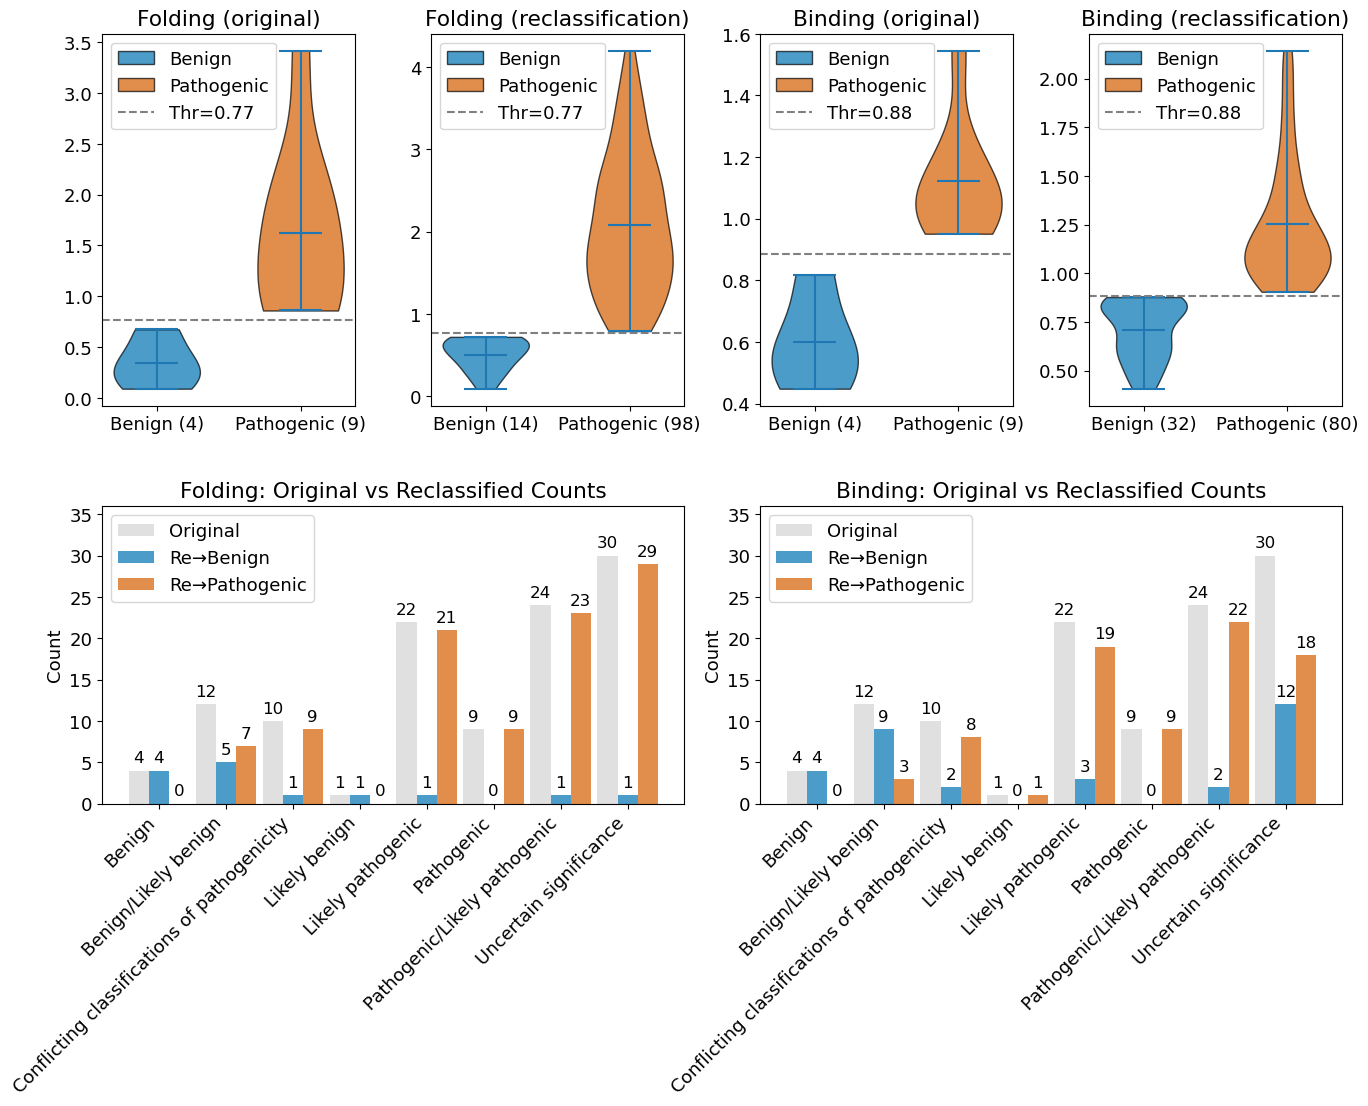

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ── Helper to tweak overall cosmetics ────────────────────────────────────────
def set_plot_cosmetics(fig,
                       fig_width=16, fig_height=10,
                       font_size=12, show_grid=False,
                       hspace=0.4, wspace=0.3):
    fig.set_size_inches(fig_width, fig_height)
    plt.rcParams.update({
        'font.size': font_size,
        'axes.grid': show_grid
    })
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

# ── Main plotting function ───────────────────────────────────────────────────
def plot_fold_bind_full(folding_path, binding_path, save_path=None,
                        # cosmetics:
                        fig_width=16, fig_height=10,
                        font_size=12, show_grid=False,
                        hspace=0.4, wspace=0.3,
                        violin_width=0.6, bar_width=0.3,
                        bar_label_font_size=None):
    """
    - save_path: if provided, saves figure to this full path.
    - bar_label_font_size: numeric font size for bar value labels (default = 0.8 * font_size).
    """
    if bar_label_font_size is None:
        bar_label_font_size = font_size * 0.8

    os.makedirs(os.path.dirname(save_path), exist_ok=True) if save_path else None

    # ── 1. Data prep ──────────────────────────────────────────────────────────
    df_fold = pd.read_excel(folding_path)
    df_fold = df_fold[df_fold['position'].between(1, 302)]
    str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
    df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)
    ben_f = df_fold[df_fold['Germline classification']=='Benign']['ddG_Fmax']
    pat_f = df_fold[df_fold['Germline classification']=='Pathogenic']['ddG_Fmax']
    thr_f = (ben_f.max() + pat_f.min()) / 2
    df_fold['Reclass_fold'] = df_fold['Germline classification']
    mask_unc = ~df_fold['Germline classification'].isin(['Benign','Pathogenic'])
    df_fold.loc[mask_unc & (df_fold['ddG_Fmax']>=thr_f), 'Reclass_fold'] = 'Pathogenic'
    df_fold.loc[mask_unc & (df_fold['ddG_Fmax']< thr_f),  'Reclass_fold'] = 'Benign'
    reben_f = df_fold[df_fold['Reclass_fold']=='Benign']['ddG_Fmax']
    repat_f = df_fold[df_fold['Reclass_fold']=='Pathogenic']['ddG_Fmax']

    df_bind = pd.read_excel(binding_path)
    df_bind = df_bind[df_bind['position'].between(1, 302)]
    ddg_cols = [c for c in df_bind.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]
    targets = {
        "SOX9":    "197-202",
        "AMPH1":   "290-294",
        "GATAD2A": "97-101",
        "ZNF219":  "111-115"
    }
    for gene, motif in targets.items():
        cols = [c for c in ddg_cols if f"_{gene}_" in c and f"_{motif}_" in c]
        if cols:
            df_bind[f"ddG_B_{gene}"] = df_bind[cols].abs().mean(axis=1)
    ddgB_cols = [f"ddG_B_{g}" for g in targets if f"ddG_B_{g}" in df_bind]
    df_bind['ddG_Bmax'] = df_bind[ddgB_cols].max(axis=1)
    ben_b = df_bind[df_bind['Germline classification']=='Benign']['ddG_Bmax']
    pat_b = df_bind[df_bind['Germline classification']=='Pathogenic']['ddG_Bmax']
    thr_b = (ben_b.max() + pat_b.min()) / 2
    df_bind['Reclass_bind'] = df_bind['Germline classification']
    mask_unc = ~df_bind['Germline classification'].isin(['Benign','Pathogenic'])
    df_bind.loc[mask_unc & (df_bind['ddG_Bmax']>=thr_b), 'Reclass_bind'] = 'Pathogenic'
    df_bind.loc[mask_unc & (df_bind['ddG_Bmax']< thr_b),  'Reclass_bind'] = 'Benign'
    reben_b = df_bind[df_bind['Reclass_bind']=='Benign']['ddG_Bmax']
    repat_b = df_bind[df_bind['Reclass_bind']=='Pathogenic']['ddG_Bmax']

    color_map = {'Benign':'#0072B2','Pathogenic':'#D55E00'}

    # ── 2. Layout & cosmetics ─────────────────────────────────────────────────
    fig = plt.figure()
    set_plot_cosmetics(fig, fig_width, fig_height, font_size, show_grid, hspace, wspace)
    gs = GridSpec(2, 4, figure=fig, height_ratios=[1,0.8], width_ratios=[1,1,1,1])

    # Row 0: 4 violins
    violins = [
        (ben_f, pat_f, "Folding (original)", thr_f),
        (reben_f, repat_f, "Folding (reclassification)", thr_f),
        (ben_b, pat_b, "Binding (original)", thr_b),
        (reben_b, repat_b, "Binding (reclassification)", thr_b),
    ]
    for i, (d0, d1, title, thr) in enumerate(violins):
        ax = fig.add_subplot(gs[0, i])
        v = ax.violinplot([d0, d1], showmeans=True, widths=violin_width)
        for body, grp in zip(v['bodies'], ['Benign','Pathogenic']):
            body.set_facecolor(color_map[grp]); body.set_edgecolor('black'); body.set_alpha(0.7)
        ax.axhline(thr, linestyle='--', color='gray')
        ax.set_xticks([1,2])
        ax.set_xticklabels([f"Benign ({len(d0)})", f"Pathogenic ({len(d1)})"])
        ax.set_title(title)
        thr_handle = Line2D([0],[0], color='gray', linestyle='--', label=f"Thr={thr:.2f}")
        handles = [
            Patch(facecolor=color_map['Benign'], edgecolor='black', alpha=0.7, label='Benign'),
            Patch(facecolor=color_map['Pathogenic'], edgecolor='black', alpha=0.7, label='Pathogenic'),
            thr_handle
        ]
        ax.legend(handles=handles, loc='upper left')

    # Row 1: bar charts
    def plot_grouped(ax, df, orig, rec, title):
        ct = pd.crosstab(df[orig], df[rec])
        idx = ct.index.tolist()
        orig_cnt = df[orig].value_counts().reindex(idx).fillna(0).values
        rb = ct.get('Benign', pd.Series(0,index=idx)).values
        rp = ct.get('Pathogenic', pd.Series(0,index=idx)).values
        x = np.arange(len(idx))

        bo = ax.bar(x-bar_width, orig_cnt, width=bar_width, color='lightgray', label='Original', alpha=0.7)
        bb = ax.bar(x, rb, width=bar_width, color=color_map['Benign'], alpha=0.7, label='Re→Benign')
        bp = ax.bar(x+bar_width, rp, width=bar_width, color=color_map['Pathogenic'], alpha=0.7, label='Re→Pathogenic')

        ymax = max(orig_cnt.max(), rb.max(), rp.max())
        ax.set_ylim(0, ymax * 1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(idx, rotation=45, ha='right')
        ax.set_ylabel("Count")
        ax.set_title(f"{title}: Original vs Reclassified Counts")

        for bar in list(bo)+list(bb)+list(bp):
            h = bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2,
                    h + ymax*0.02, int(h),
                    ha='center', va='bottom',
                    fontsize=bar_label_font_size)
        ax.legend()

    ax1 = fig.add_subplot(gs[1, 0:2])
    plot_grouped(ax1, df_fold, 'Germline classification', 'Reclass_fold', 'Folding')
    ax2 = fig.add_subplot(gs[1, 2:4])
    plot_grouped(ax2, df_bind, 'Germline classification', 'Reclass_bind', 'Binding')

    # ── 3. Save and show ───────────────────────────────────────────────────────
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
if __name__ == "__main__":
    plot_fold_bind_full(
        folding_path="/project/ealexov/compbio/shamrat/250519_energy/02_folding/"
                     "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx",
        binding_path="/project/ealexov/compbio/shamrat/250519_energy/04_binding/"
                     "clinvar_1kgp_hector_gaf_final_binding.xlsx",
        save_path="/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification/"
                  "fold_bind_full.png",
        fig_width=16,
        fig_height=10,
        font_size=13,
        show_grid=False,
        hspace=0.3,
        wspace=0.3,
        violin_width=0.6,
        bar_width=0.3,
        bar_label_font_size=12
    )


## 5.4 Variant reclassification statistics

In [2]:
import os
import pandas as pd
import numpy as np

# ── Paths ────────────────────────────────────────────────────────────────────
root         = "/project/ealexov/compbio/shamrat/250519_energy"
folding_path = os.path.join(root, "02_folding",
                            "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx")
binding_path = os.path.join(root, "04_binding",
                            "analysis/clinvar_1kgp_hector_gaf_final_binding.xlsx")

# ── 1. Folding data prep ─────────────────────────────────────────────────────
df_fold = pd.read_excel(folding_path)
df_fold = df_fold[df_fold['position'].between(1,302)]
# structure-based columns (exclude FoldX)
str_cols = [c for c in df_fold.columns if c.endswith("_str") and "foldx" not in c.lower()]
df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

# original groups
orig_ben_f = df_fold.loc[df_fold['Germline classification']=="Benign", "ddG_Fmax"]
orig_pat_f = df_fold.loc[df_fold['Germline classification']=="Pathogenic", "ddG_Fmax"]
thr_f      = (orig_ben_f.max() + orig_pat_f.min()) / 2

# reclassified (only uncertain get flipped)
df_fold['Reclass_fold'] = df_fold['Germline classification']
mask_unc = ~df_fold['Germline classification'].isin(["Benign","Pathogenic"])
df_fold.loc[mask_unc & (df_fold['ddG_Fmax']>=thr_f), "Reclass_fold"] = "Pathogenic"
df_fold.loc[mask_unc & (df_fold['ddG_Fmax']< thr_f), "Reclass_fold"] = "Benign"

re_ben_f = df_fold.loc[df_fold['Reclass_fold']=="Benign", "ddG_Fmax"]
re_pat_f = df_fold.loc[df_fold['Reclass_fold']=="Pathogenic", "ddG_Fmax"]

# ── 2. Binding data prep ─────────────────────────────────────────────────────
df_bind = pd.read_excel(binding_path)
df_bind = df_bind[df_bind['position'].between(1,302)]
ddg_cols = [c for c in df_bind.columns if c.startswith("ddg_") and "_str_" in c and "foldx" not in c.lower()]
targets  = {
    "SOX9":"197-202", "AMPH1":"290-294",
    "GATAD2A":"97-101","ZNF219":"111-115"
}
for gene,motif in targets.items():
    cols = [c for c in ddg_cols if f"_{gene}_" in c and f"_{motif}_" in c]
    if cols:
        df_bind[f"ddG_B_{gene}"] = df_bind[cols].abs().mean(axis=1)

b_cols      = [c for c in df_bind.columns if c.startswith("ddG_B_")]
df_bind['ddG_Bmax'] = df_bind[b_cols].max(axis=1)

orig_ben_b = df_bind.loc[df_bind['Germline classification']=="Benign", "ddG_Bmax"]
orig_pat_b = df_bind.loc[df_bind['Germline classification']=="Pathogenic", "ddG_Bmax"]
thr_b      = (orig_ben_b.max() + orig_pat_b.min()) / 2

df_bind['Reclass_bind'] = df_bind['Germline classification']
mask_unc = ~df_bind['Germline classification'].isin(["Benign","Pathogenic"])
df_bind.loc[mask_unc & (df_bind['ddG_Bmax']>=thr_b), "Reclass_bind"] = "Pathogenic"
df_bind.loc[mask_unc & (df_bind['ddG_Bmax']< thr_b), "Reclass_bind"] = "Benign"

re_ben_b = df_bind.loc[df_bind['Reclass_bind']=="Benign", "ddG_Bmax"]
re_pat_b = df_bind.loc[df_bind['Reclass_bind']=="Pathogenic", "ddG_Bmax"]

# ── 3. Print summaries ───────────────────────────────────────────────────────

print("FOLDING (original):")
print(f"  Benign (n={len(orig_ben_f)}): ddG_Fmax range {orig_ben_f.min():.3f}–{orig_ben_f.max():.3f}, mean {orig_ben_f.mean():.3f}")
print(f"  Pathogenic (n={len(orig_pat_f)}): ddG_Fmax range {orig_pat_f.min():.3f}–{orig_pat_f.max():.3f}, mean {orig_pat_f.mean():.3f}")
print(f"  Threshold (Thr): {thr_f:.3f}\n")

print("FOLDING (reclassified):")
print(f"  Benign (n={len(re_ben_f)}): ddG_Fmax range {re_ben_f.min():.3f}–{re_ben_f.max():.3f}, mean {re_ben_f.mean():.3f}")
print(f"  Pathogenic (n={len(re_pat_f)}): ddG_Fmax range {re_pat_f.min():.3f}–{re_pat_f.max():.3f}, mean {re_pat_f.mean():.3f}")
print("  Reclassification counts:")
print(pd.crosstab(df_fold['Germline classification'], df_fold['Reclass_fold']))
print()

print("BINDING (original):")
print(f"  Benign (n={len(orig_ben_b)}): ddG_Bmax range {orig_ben_b.min():.3f}–{orig_ben_b.max():.3f}, mean {orig_ben_b.mean():.3f}")
print(f"  Pathogenic (n={len(orig_pat_b)}): ddG_Bmax range {orig_pat_b.min():.3f}–{orig_pat_b.max():.3f}, mean {orig_pat_b.mean():.3f}")
print(f"  Threshold (Thr): {thr_b:.3f}\n")

print("BINDING (reclassified):")
print(f"  Benign (n={len(re_ben_b)}): ddG_Bmax range {re_ben_b.min():.3f}–{re_ben_b.max():.3f}, mean {re_ben_b.mean():.3f}")
print(f"  Pathogenic (n={len(re_pat_b)}): ddG_Bmax range {re_pat_b.min():.3f}–{re_pat_b.max():.3f}, mean {re_pat_b.mean():.3f}")
print("  Reclassification counts:")
print(pd.crosstab(df_bind['Germline classification'], df_bind['Reclass_bind']))


FOLDING (original):
  Benign (n=4): ddG_Fmax range 0.090–0.675, mean 0.342
  Pathogenic (n=9): ddG_Fmax range 0.860–3.420, mean 1.626
  Threshold (Thr): 0.768

FOLDING (reclassified):
  Benign (n=14): ddG_Fmax range 0.090–0.720, mean 0.505
  Pathogenic (n=98): ddG_Fmax range 0.790–4.200, mean 2.083
  Reclassification counts:
Reclass_fold                                  Benign  Pathogenic
Germline classification                                         
Benign                                             4           0
Benign/Likely benign                               5           7
Conflicting classifications of pathogenicity       1           9
Likely benign                                      1           0
Likely pathogenic                                  1          21
Pathogenic                                         0           9
Pathogenic/Likely pathogenic                       1          23
Uncertain significance                             1          29

BINDING (original):
  

## 5.5 Reclassified ddG_Fmax > ddG_Bmax (pathogenic in both)


=== LIST A — Folding>Binding AND (Reclass_fold OR Reclass_bind is Pathogenic) ===


,position,mutation,ddG_Fmax,ddG_Bmax,Reclass_fold,Reclass_bind,Comparison,targets_present
0,13,F13S,3.658,1.062811,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
1,20,G20D,2.250,1.123913,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
2,20,G20R,1.400,1.174369,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
3,21,E21G,1.710,1.010605,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
4,22,G22E,1.150,1.139024,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
5,22,G22V,1.570,0.838518,Pathogenic,Benign,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
6,24,Y24C,1.400,1.050972,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
7,27,V27A,2.460,1.145492,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
8,30,C30Y,2.410,0.922735,Pathogenic,Pathogenic,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219
9,31,R31G,2.170,0.856541,Pathogenic,Benign,Folding>Binding,SOX9;AMPH1;GATAD2A;ZNF219


Count (List A): 86

=== LIST B — Rest (≤) AND (Reclass_fold OR Reclass_bind is Pathogenic) ===


,position,mutation,ddG_Fmax,ddG_Bmax,Reclass_fold,Reclass_bind,Comparison,targets_present
0,20,G20V,0.89,0.951424,Pathogenic,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
1,25,G25R,1.60,1.744254,Pathogenic,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
2,40,A40V,0.86,1.005493,Pathogenic,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
3,59,R59P,1.14,1.345695,Pathogenic,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
4,65,R65Q,0.44,1.167515,Benign,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
5,80,R80L,0.60,0.946886,Benign,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
6,127,H127Y,0.89,0.966060,Pathogenic,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
7,153,D153V,0.72,0.951144,Benign,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
8,172,V172I,0.51,2.033288,Benign,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219
9,173,A173D,0.84,2.133559,Pathogenic,Pathogenic,Rest (≤),SOX9;AMPH1;GATAD2A;ZNF219


Count (List B): 17

Saved master annotated CSV to: /project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification/ddg_folding_vs_binding_4targets_all.csv
Saved LIST A to: /project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification/folding_gt_binding_pathogenic_any.csv
Saved LIST B to: /project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification/rest_pathogenic_any.csv


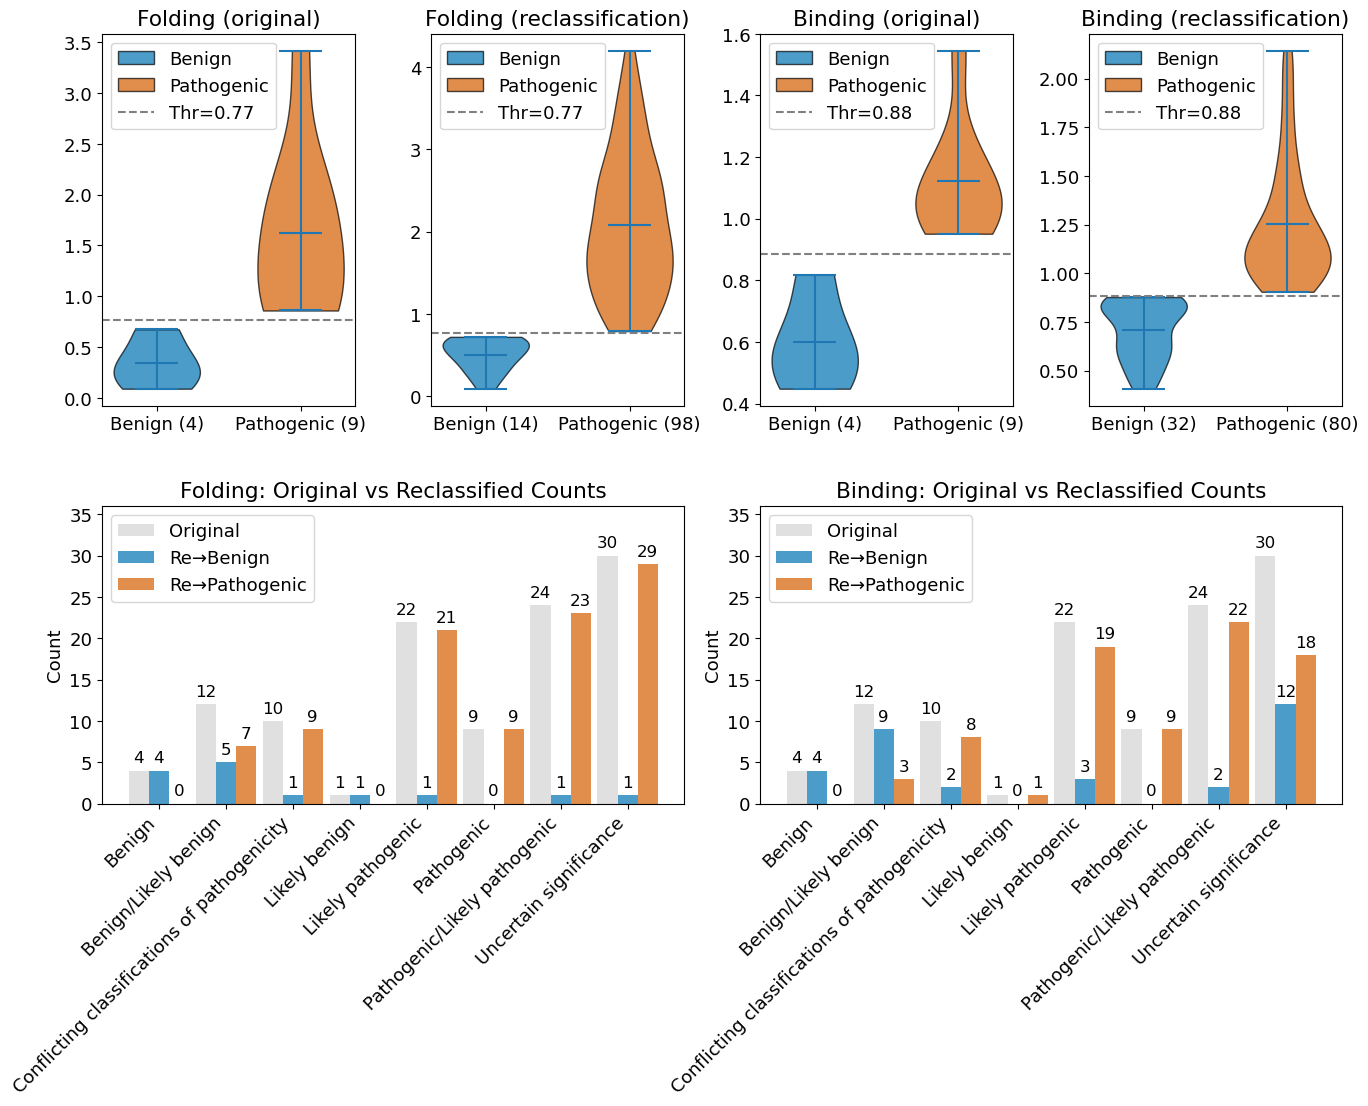

In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Optional: pretty display in notebooks
try:
    from IPython.display import display
    _HAS_IPY = True
except Exception:
    _HAS_IPY = False

# ── Helper to tweak overall cosmetics ────────────────────────────────────────
def set_plot_cosmetics(fig,
                       fig_width=16, fig_height=10,
                       font_size=12, show_grid=False,
                       hspace=0.4, wspace=0.3):
    fig.set_size_inches(fig_width, fig_height)
    plt.rcParams.update({
        'font.size': font_size,
        'axes.grid': show_grid
    })
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

# ── Main plotting + export function ──────────────────────────────────────────
def plot_fold_bind_full(folding_path, binding_path, save_path=None,
                        # cosmetics:
                        fig_width=16, fig_height=10,
                        font_size=12, show_grid=False,
                        hspace=0.4, wspace=0.3,
                        violin_width=0.6, bar_width=0.3,
                        bar_label_font_size=None):
    """
    - save_path: if provided, saves figure and CSVs into the same folder.
      CSVs written:
        - ddg_folding_vs_binding_4targets_all.csv (master annotated table)
        - folding_gt_binding_pathogenic_any.csv   (List A)
        - rest_pathogenic_any.csv                  (List B)
    """
    if bar_label_font_size is None:
        bar_label_font_size = font_size * 0.8

    os.makedirs(os.path.dirname(save_path), exist_ok=True) if save_path else None

    # ── 1. Data prep ──────────────────────────────────────────────────────────
    # Folding data
    df_fold = pd.read_excel(folding_path)
    df_fold = df_fold[df_fold['position'].between(1, 302)]
    str_cols = [c for c in df_fold.columns if c.endswith('_str') and 'foldx' not in c.lower()]
    df_fold['ddG_Fmax'] = df_fold[str_cols].abs().max(axis=1)

    ben_f = df_fold[df_fold['Germline classification']=='Benign']['ddG_Fmax']
    pat_f = df_fold[df_fold['Germline classification']=='Pathogenic']['ddG_Fmax']
    thr_f = (ben_f.max() + pat_f.min()) / 2

    df_fold['Reclass_fold'] = df_fold['Germline classification']
    mask_unc_f = ~df_fold['Germline classification'].isin(['Benign','Pathogenic'])
    df_fold.loc[mask_unc_f & (df_fold['ddG_Fmax']>=thr_f), 'Reclass_fold'] = 'Pathogenic'
    df_fold.loc[mask_unc_f & (df_fold['ddG_Fmax']< thr_f),  'Reclass_fold'] = 'Benign'

    # Binding data
    df_bind = pd.read_excel(binding_path)
    df_bind = df_bind[df_bind['position'].between(1, 302)]
    ddg_cols = [c for c in df_bind.columns if c.startswith('ddg_') and '_str_' in c and 'foldx' not in c.lower()]

    targets = {
        "SOX9":    "197-202",
        "AMPH1":   "290-294",
        "GATAD2A": "97-101",
        "ZNF219":  "111-115"
    }
    for gene, motif in targets.items():
        cols = [c for c in ddg_cols if f"_{gene}_" in c and f"_{motif}_" in c]
        if cols:
            df_bind[f"ddG_B_{gene}"] = df_bind[cols].abs().mean(axis=1)

    ddgB_cols = [f"ddG_B_{g}" for g in targets if f"ddG_B_{g}" in df_bind]
    df_bind['ddG_Bmax'] = df_bind[ddgB_cols].max(axis=1)

    ben_b = df_bind[df_bind['Germline classification']=='Benign']['ddG_Bmax']
    pat_b = df_bind[df_bind['Germline classification']=='Pathogenic']['ddG_Bmax']
    thr_b = (ben_b.max() + pat_b.min()) / 2

    df_bind['Reclass_bind'] = df_bind['Germline classification']
    mask_unc_b = ~df_bind['Germline classification'].isin(['Benign','Pathogenic'])
    df_bind.loc[mask_unc_b & (df_bind['ddG_Bmax']>=thr_b), 'Reclass_bind'] = 'Pathogenic'
    df_bind.loc[mask_unc_b & (df_bind['ddG_Bmax']< thr_b),  'Reclass_bind'] = 'Benign'

    # ── 2. Build single annotated table (4-target filter) ─────────────────────
    fold_ddg = df_fold[['position', 'mutation', 'ddG_Fmax', 'Reclass_fold']]

    intended_target_cols = ['ddG_B_SOX9', 'ddG_B_AMPH1', 'ddG_B_GATAD2A', 'ddG_B_ZNF219']
    existing_target_cols = [c for c in intended_target_cols if c in df_bind.columns]

    bind_cols_keep = ['position', 'mutation', 'ddG_Bmax', 'Reclass_bind'] + existing_target_cols
    bind_ddg = df_bind[bind_cols_keep]

    # Merge folding + binding info
    annotated = pd.merge(fold_ddg, bind_ddg, on=['position', 'mutation'], how='inner')

    # Keep only mutations tied to at least one of the four targets
    if existing_target_cols:
        has_target = annotated[existing_target_cols].notna().any(axis=1)
    else:
        has_target = pd.Series(False, index=annotated.index)

    annotated = annotated[has_target].copy()

    # Add annotation: Folding>Binding vs Rest
    annotated['Comparison'] = np.where(
        annotated['ddG_Fmax'] > annotated['ddG_Bmax'],
        'Folding>Binding',
        'Rest (≤)'
    )

    # Optional: which targets present
    def list_targets(row):
        present = [t.split('_')[-1] for t in existing_target_cols if pd.notna(row[t])]
        return ';'.join(present) if present else ''
    annotated['targets_present'] = annotated.apply(list_targets, axis=1)

    # Sort: Folding>Binding first, then position, mutation
    comp_order = pd.CategoricalDtype(categories=['Folding>Binding', 'Rest (≤)'], ordered=True)
    annotated['Comparison'] = annotated['Comparison'].astype(comp_order)
    annotated.sort_values(['Comparison', 'position', 'mutation'], inplace=True)

    # Columns to show/save
    cols_to_save = ['position','mutation','ddG_Fmax','ddG_Bmax',
                    'Reclass_fold','Reclass_bind','Comparison','targets_present']

    # ── 3. Derive the TWO requested lists ─────────────────────────────────────
    subset_fgb  = annotated[annotated['Comparison'] == 'Folding>Binding'].copy()
    subset_rest = annotated[annotated['Comparison'] == 'Rest (≤)'].copy()

    # Pathogenic if at least one of the reclass labels is Pathogenic
    any_path_cond = ( (subset_fgb['Reclass_fold'] == 'Pathogenic') |
                      (subset_fgb['Reclass_bind'] == 'Pathogenic') )
    listA_fgb_path_any = subset_fgb[any_path_cond][cols_to_save].reset_index(drop=True)

    any_path_cond_rest = ( (subset_rest['Reclass_fold'] == 'Pathogenic') |
                           (subset_rest['Reclass_bind'] == 'Pathogenic') )
    listB_rest_path_any = subset_rest[any_path_cond_rest][cols_to_save].reset_index(drop=True)

    # ── 4. Display FULL tables (no truncation) and brief counts ───────────────
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

    if _HAS_IPY:
        print("\n=== LIST A — Folding>Binding AND (Reclass_fold OR Reclass_bind is Pathogenic) ===")
        display(listA_fgb_path_any)
        print(f"Count (List A): {listA_fgb_path_any.shape[0]}")

        print("\n=== LIST B — Rest (≤) AND (Reclass_fold OR Reclass_bind is Pathogenic) ===")
        display(listB_rest_path_any)
        print(f"Count (List B): {listB_rest_path_any.shape[0]}")
    else:
        print("\n=== LIST A — Folding>Binding AND (Reclass_fold OR Reclass_bind is Pathogenic) ===")
        print(listA_fgb_path_any)
        print(f"Count (List A): {listA_fgb_path_any.shape[0]}")

        print("\n=== LIST B — Rest (≤) AND (Reclass_fold OR Reclass_bind is Pathogenic) ===")
        print(listB_rest_path_any)
        print(f"Count (List B): {listB_rest_path_any.shape[0]}")

    # Reset display options
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

    # ── 5. Save CSVs (master + the two lists) if save_path is given ───────────
    if save_path:
        out_dir = os.path.dirname(save_path)
        master_csv = os.path.join(out_dir, "ddg_folding_vs_binding_4targets_all.csv")
        listA_csv  = os.path.join(out_dir, "folding_gt_binding_pathogenic_any.csv")
        listB_csv  = os.path.join(out_dir, "rest_pathogenic_any.csv")

        annotated[cols_to_save].to_csv(master_csv, index=False)
        listA_fgb_path_any.to_csv(listA_csv, index=False)
        listB_rest_path_any.to_csv(listB_csv, index=False)

        print(f"\nSaved master annotated CSV to: {master_csv}")
        print(f"Saved LIST A to: {listA_csv}")
        print(f"Saved LIST B to: {listB_csv}")

    # ── 6. Plotting (same as before) ──────────────────────────────────────────
    color_map = {'Benign':'#0072B2','Pathogenic':'#D55E00'}
    fig = plt.figure()
    set_plot_cosmetics(fig, fig_width, fig_height, font_size, show_grid, hspace, wspace)
    gs = GridSpec(2, 4, figure=fig, height_ratios=[1,0.8], width_ratios=[1,1,1,1])

    violins = [
        (df_fold[df_fold['Germline classification']=='Benign']['ddG_Fmax'],
         df_fold[df_fold['Germline classification']=='Pathogenic']['ddG_Fmax'],
         "Folding (original)", thr_f),
        (df_fold[df_fold['Reclass_fold']=='Benign']['ddG_Fmax'],
         df_fold[df_fold['Reclass_fold']=='Pathogenic']['ddG_Fmax'],
         "Folding (reclassification)", thr_f),
        (df_bind[df_bind['Germline classification']=='Benign']['ddG_Bmax'],
         df_bind[df_bind['Germline classification']=='Pathogenic']['ddG_Bmax'],
         "Binding (original)", thr_b),
        (df_bind[df_bind['Reclass_bind']=='Benign']['ddG_Bmax'],
         df_bind[df_bind['Reclass_bind']=='Pathogenic']['ddG_Bmax'],
         "Binding (reclassification)", thr_b),
    ]

    for i, (d0, d1, title, thr) in enumerate(violins):
        ax = fig.add_subplot(gs[0, i])
        v = ax.violinplot([d0, d1], showmeans=True, widths=violin_width)
        for body, grp in zip(v['bodies'], ['Benign','Pathogenic']):
            body.set_facecolor(color_map[grp]); body.set_edgecolor('black'); body.set_alpha(0.7)
        ax.axhline(thr, linestyle='--', color='gray')
        ax.set_xticks([1,2])
        ax.set_xticklabels([f"Benign ({len(d0)})", f"Pathogenic ({len(d1)})"])
        ax.set_title(title)
        thr_handle = Line2D([0],[0], color='gray', linestyle='--', label=f"Thr={thr:.2f}")
        handles = [
            Patch(facecolor=color_map['Benign'], edgecolor='black', alpha=0.7, label='Benign'),
            Patch(facecolor=color_map['Pathogenic'], edgecolor='black', alpha=0.7, label='Pathogenic'),
            thr_handle
        ]
        ax.legend(handles=handles, loc='upper left')

    def plot_grouped(ax, df, orig, rec, title):
        ct = pd.crosstab(df[orig], df[rec])
        idx = ct.index.tolist()
        orig_cnt = df[orig].value_counts().reindex(idx).fillna(0).values
        rb = ct.get('Benign', pd.Series(0,index=idx)).values
        rp = ct.get('Pathogenic', pd.Series(0,index=idx)).values
        x = np.arange(len(idx))

        bo = ax.bar(x-bar_width, orig_cnt, width=bar_width, color='lightgray', label='Original', alpha=0.7)
        bb = ax.bar(x, rb, width=bar_width, color=color_map['Benign'], alpha=0.7, label='Re→Benign')
        bp = ax.bar(x+bar_width, rp, width=bar_width, color=color_map['Pathogenic'], alpha=0.7, label='Re→Pathogenic')

        ymax = max(orig_cnt.max(), rb.max(), rp.max())
        ax.set_ylim(0, ymax * 1.2)
        ax.set_xticks(x)
        ax.set_xticklabels(idx, rotation=45, ha='right')
        ax.set_ylabel("Count")
        ax.set_title(f"{title}: Original vs Reclassified Counts")

        for bar in list(bo)+list(bb)+list(bp):
            h = bar.get_height()
            ax.text(bar.get_x()+bar.get_width()/2,
                    h + ymax*0.02, int(h),
                    ha='center', va='bottom',
                    fontsize=bar_label_font_size)
        ax.legend()

    ax1 = fig.add_subplot(gs[1, 0:2])
    plot_grouped(ax1, df_fold, 'Germline classification', 'Reclass_fold', 'Folding')
    ax2 = fig.add_subplot(gs[1, 2:4])
    plot_grouped(ax2, df_bind, 'Germline classification', 'Reclass_bind', 'Binding')

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
if __name__ == "__main__":
    plot_fold_bind_full(
        folding_path="/project/ealexov/compbio/shamrat/250519_energy/02_folding/"
                     "01_cdkl5_clinvar_gaf_1kgp_hctr_comb_unq_af.xlsx",
        binding_path="/project/ealexov/compbio/shamrat/250519_energy/04_binding/"
                     "clinvar_1kgp_hector_gaf_final_binding.xlsx",
        save_path="/project/ealexov/compbio/shamrat/250519_energy/04.5_reclassification/"
                  "fold_bind_full.png",
        fig_width=16,
        fig_height=10,
        font_size=13,
        show_grid=False,
        hspace=0.3,
        wspace=0.3,
        violin_width=0.6,
        bar_width=0.3,
        bar_label_font_size=12
    )
